# Classification Random Forest for Fight Delay Predictor

## Reserach

### Model Selection

In my initail EDA, looking initially at the data Plots like this:

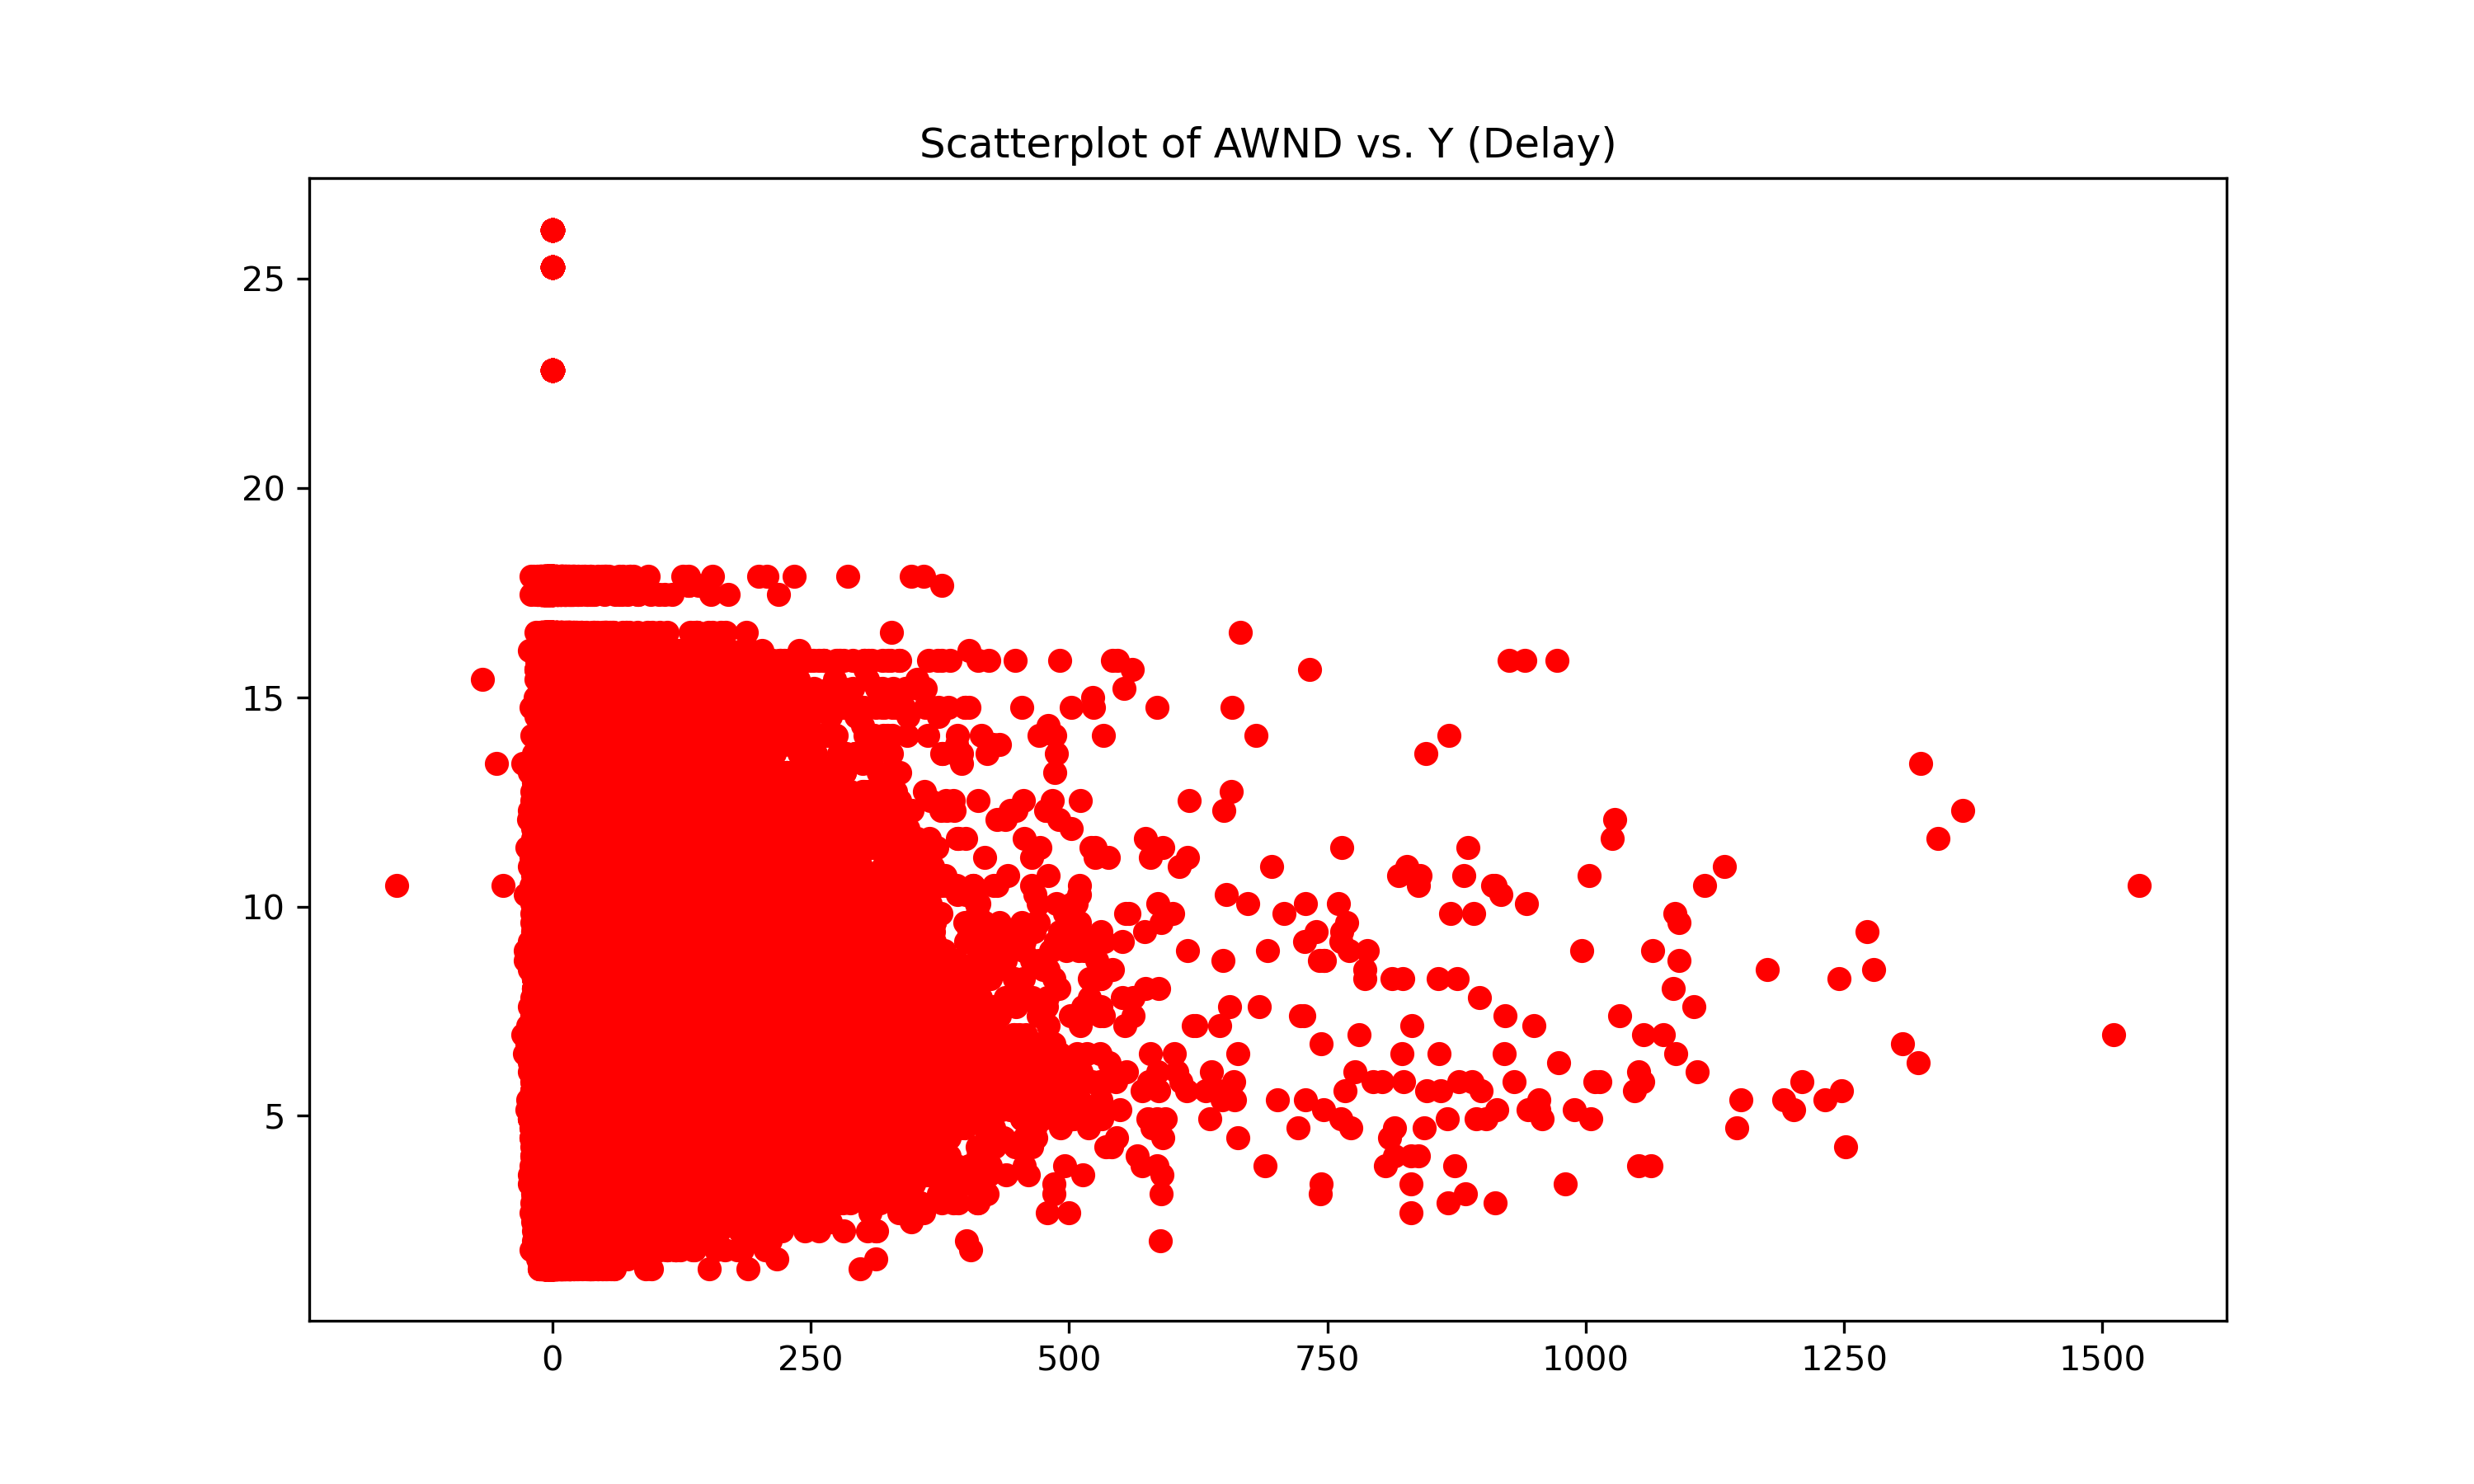

You can see that we have a clear violation of linearality and therefore need to look at models beyond linear and logistic regression. We also have many catagorical varaible which are harder to handle with linear and logistic regression. With that in mind, while there are a few models that could help with this, I found that with a good amount of binary varaibles and catagories in our variables, Random Forest would be a good model to test. There are other models that could work which have been done by other group mates.

### **Delay: our Y variable**

This portion of the project is to find a pattern in our dataset that can let us predict if a flight will be delayed or not. This means our Y response variable is a binary variable, and we need to fit a classification Random Forest. 

Our dataset does not define what counts as a delay but the Bureau of Transportation Statistics does, claiming anything past 15 minutes is a delay.
https://www.bts.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays

This is simple enough to code, with a single line, found as the first line in **Data Preparation**

### **Our Predictor Variables: How we narrow down**

#### **Ones to eliminate**

**'Unique_ID'** and **'Flight Number'**

These are indexing variables and are very easy to remove from a final model.

**'Carrier Code'** 

We found Carrier Code to be the same as Airline and for the purpose of the project removed this first

**'Scheduled departure time'** and **'Actual departure time',**

These variables were used by the dataset to make our Y response of Delay, these will very clearly violate assumptions of collinearity 

**'Delay Carrier (Minutes)'**, **'Delay Weather (Minutes)'**, **'Delay National Aviation System (Minutes)'**, **'Delay Security (Minutes)'** and **'Delay Late Aircraft Arrival (Minutes)'**

These variables can be important but are clearly made up of there being a delay, so these will be severely collinear. But these are really nice variables to use to build as their own forests

#### **Ones to alter**

**'Destination Airport'**

In order to make easier generalizations for the model, we decided to group Destination Airport into two new features, **Destination Region** and **Destination State** in which the destination airport was grouped into a state region or desination state

**'Scheduled elapsed time (Minutes)'** and **'Actual elapsed time (Minutes)'** 

These were altered to make a new variable, **Elapsed Time Difference**, which takes the difference of the two variables

**'TMAX'** and **'TMIN'**

To help control outliers and minimize features, we made the Mean of the two temperatures, **'TMean'**


**'Holiday'**

Using this feature of holidays, we made **Holiday_Proximity** to signify if a flight was within 3 days of a National holiday.

**'WT01'**, **'WT02'**, **'WT03'**, **'WT05'**, **'WT08'**, **'WT10'**, **'WT11'**, **'WT13'**, **'WT14'**, **'WT16'** and **'WT21'**

We found that the frequency of these variables was not too high, and found that to minimize features, if we had a variable that said if even one of these is true, we mark it, it would still give results. Therefore we have **WTTrue**

**'Date (MM/DD/YYYY)'**

Date is known to be a hard variable to work with, and is accessed by another project. But we wanted to make some features from it, for this we made **Month** , where we grouped each month.

#### **Features to Include**

**'Departure delay (Minutes)'**

As talked about before, this is our response variable

**'Airline'**, **'Month'**, **'Destination Region'**, **'Elapsed Time Difference'**, **'WTTrue'**, **'TMean'**, **'Holiday_Proximity'** and **'Destination State'**

Alterations to features shown in the Alterations section

**'Tail Number'**,

Tail Number is the id number of each individual plane, so we can see which planes have more delays.

**'AWND'**, **'PRCP'**,

### **Random Forest Parameters**

#### **Criterion**

Criterion, or the optimum split criterion, is a formula used when making a tree, in which it measures the viability of a split. Once a split is made, running the criterion lets the algorithm know if this split is effective or not.

There are two possible criterions to look at 'Gini' and 'Entropy'

**Gini** 

Given by the formula: 
$1 - \sum_{j} p_j^2$ &nbsp; &nbsp; Where p_j is the probability of that given class j.

This formula looks to see the probability of each node to correctly predict the outcome, and compares the two nodes.

**Entropy**

Given by the formula: 
$-\sum_{j} p_j \cdot \log_2 p_j$

This formula looks at the distribution of samples and its accuracy for each node and calculates an entropy score.

Formulas and descriptions can be found in this link.
https://quantdare.com/decision-trees-gini-vs-entropy/

The article also found Entropy to be slightly more accurate but with a longer run time. My first few runs had scores not too ideal so I am testing Entropy first to get the slight edge.

#### **n_estimators**

N_estimators is the amount of trees in a forest. This was tested with Hyperparameters

#### **min_samples_split**

#### **max_depth**

#### **max_features**

#### **class_weight**

### Model Scoring

When looking at Classification, we want to look at Classification Scoring:

**Precision**:

Of the amount predicted, how many were correct

**Recall**:

Of all the possible correct samples, how many did you get?

**F1-score**:

Combined scoring of Precision and Recall

Info: https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397

### Initial Code

Import all Packeges to be used and read in the CSV

In [269]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split


Get CSV and assign it a value

In [272]:
Full_Flight_Data = pd.read_csv("/Users/isaacvalencia/Desktop/Projects/AmStat_Flight_Delays/Combined_Airline_Data.csv")

### Data Cleaning

When importing the data had NA for when there wasn't a weather variable present but for cleaning purposes we will use 0

In [275]:
##Turn all NA in the weather variables into 0's
weather_variables = Full_Flight_Data.iloc[:, -12:]
Full_Flight_Data.iloc[:, -12:] = weather_variables.fillna(0)

### Data Preparation

We are looking at Classification with our delay feature, so we make a binary variable for delay vs. no delay. We also have some dictionaries from Sarah

In [277]:
Full_Flight_Data['Departure delay (Minutes)'] = Full_Flight_Data['Departure delay (Minutes)'].apply(lambda x: 'Delay' if x > 15.0 else 'No Delay')

Some other code from Sarah for feature alterations for the  model

In [280]:
## All code in this block was borrowed from Sarah

## Make date and month columns
Full_Flight_Data['Date (MM/DD/YYYY)'] = pd.to_datetime(Full_Flight_Data['Date (MM/DD/YYYY)'])
Full_Flight_Data['Month'] = Full_Flight_Data['Date (MM/DD/YYYY)'].dt.month

## Make a value for the mean temperature of the day
Full_Flight_Data['TMean'] = (Full_Flight_Data['TMAX'] + Full_Flight_Data['TMIN']) / 2

## Make a weather present feature
weatherColumns = [col for col in Full_Flight_Data.columns if col.startswith('WT')]
Full_Flight_Data['WTTrue'] = Full_Flight_Data[weatherColumns].sum(axis=1) > 0

## Make and Elapsed Time Difference feature
Full_Flight_Data['Elapsed Time Difference'] = Full_Flight_Data['Actual elapsed time (Minutes)'] - Full_Flight_Data['Scheduled elapsed time (Minutes)']

## Create a feature for state and region
Full_Flight_Data['Destination State'] = Full_Flight_Data['Destination Airport'].map(airportToState)
Full_Flight_Data['Destination Region'] = Full_Flight_Data['Destination State'].map(stateToRegion)

In [281]:
###Necessary Dictionaries for later columns code block borrowed from SARAH
airportToState = {    
    'ABE': 'PA',  # Lehigh Valley International Airport
    'ABQ': 'NM',  # Albuquerque International Sunport
    'ACY': 'NJ',  # Atlantic City International Airport
    'ALB': 'NY',  # Albany International Airport
    'ATL': 'GA',  # Hartsfield–Jackson Atlanta International Airport
    'AUS': 'TX',  # Austin–Bergstrom International Airport
    'BDL': 'CT',  # Bradley International Airport
    'BHM': 'AL',  # Birmingham-Shuttlesworth International Airport
    'BKG': 'MO',  # Branson Airport
    'BMI': 'IL',  # Central Illinois Regional Airport at Bloomington–Normal
    'BNA': 'TN',  # Nashville International Airport
    'BOS': 'MA',  # Logan International Airport
    'BQN': 'PR',  # Rafael Hernández Airport (Puerto Rico)
    'BUF': 'NY',  # Buffalo Niagara International Airport
    'BWI': 'MD',  # Baltimore/Washington International Thurgood Marshall Airport
    'CAK': 'OH',  # Akron-Canton Airport
    'CID': 'IA',  # The Eastern Iowa Airport
    'CLE': 'OH',  # Cleveland Hopkins International Airport
    'CLT': 'NC',  # Charlotte Douglas International Airport
    'CMH': 'OH',  # John Glenn Columbus International Airport
    'COS': 'CO',  # Colorado Springs Airport
    'COU': 'MO',  # Columbia Regional Airport
    'CVG': 'KY',  # Cincinnati/Northern Kentucky International Airport
    'DAL': 'TX',  # Dallas Love Field
    'DAY': 'OH',  # Dayton International Airport
    'DCA': 'VA',  # Ronald Reagan Washington National Airport
    'DEN': 'CO',  # Denver International Airport
    'DFW': 'TX',  # Dallas/Fort Worth International Airport
    'DSM': 'IA',  # Des Moines International Airport
    'DTW': 'MI',  # Detroit Metropolitan Wayne County Airport
    'ECP': 'FL',  # Northwest Florida Beaches International Airport
    'EWR': 'NJ',  # Newark Liberty International Airport
    'EYW': 'FL',  # Key West International Airport
    'FLL': 'FL',  # Fort Lauderdale-Hollywood International Airport
    'FNT': 'MI',  # Bishop International Airport (Flint)
    'GRR': 'MI',  # Gerald R. Ford International Airport (Grand Rapids)
    'GSO': 'NC',  # Piedmont Triad International Airport (Greensboro)
    'GSP': 'SC',  # Greenville-Spartanburg International Airport
    'HOU': 'TX',  # William P. Hobby Airport (Houston)
    'HPN': 'NY',  # Westchester County Airport (White Plains)
    'IAD': 'VA',  # Washington Dulles International Airport
    'IAG': 'NY',  # Niagara Falls International Airport
    'IAH': 'TX',  # George Bush Intercontinental Airport (Houston)
    'ILG': 'DE',  # Wilmington Airport (Delaware)
    'IND': 'IN',  # Indianapolis International Airport
    'ISP': 'NY',  # Long Island MacArthur Airport (Islip)
    'JAN': 'MS',  # Jackson–Medgar Wiley Evers International Airport
    'JFK': 'NY',  # John F. Kennedy International Airport
    'LAS': 'NV',  # Harry Reid International Airport (Las Vegas)
    'LAX': 'CA',  # Los Angeles International Airport
    'LBE': 'PA',  # Arnold Palmer Regional Airport (Latrobe)
    'LGA': 'NY',  # LaGuardia Airport (New York City)
    'LIT': 'AR',  # Bill and Hillary Clinton National Airport (Little Rock)
    'MCI': 'MO',  # Kansas City International Airport
    'MDT': 'PA',  # Harrisburg International Airport
    'MDW': 'IL',  # Chicago Midway International Airport
    'MEM': 'TN',  # Memphis International Airport
    'MHT': 'NH',  # Manchester-Boston Regional Airport
    'MIA': 'FL',  # Miami International Airport
    'MKE': 'WI',  # Milwaukee Mitchell International Airport
    'MSN': 'WI',  # Dane County Regional Airport (Madison)
    'MSP': 'MN',  # Minneapolis–Saint Paul International Airport
    'MSY': 'LA',  # Louis Armstrong New Orleans International Airport
    'OKC': 'OK',  # Will Rogers World Airport (Oklahoma City)
    'OMA': 'NE',  # Eppley Airfield (Omaha)
    'ORD': 'IL',  # Chicago O'Hare International Airport
    'ORF': 'VA',  # Norfolk International Airport
    'ORH': 'MA',  # Worcester Regional Airport
    'PBG': 'NY',  # Plattsburgh International Airport
    'PDX': 'OR',  # Portland International Airport
    'PHL': 'PA',  # Philadelphia International Airport
    'PHX': 'AZ',  # Phoenix Sky Harbor International Airport
    'PIT': 'PA',  # Pittsburgh International Airport
    'PSE': 'PR',  # Mercedita International Airport (Ponce, Puerto Rico)
    'PVD': 'RI',  # T. F. Green Airport (Providence)
    'PWM': 'ME',  # Portland International Jetport (Maine)
    'RDU': 'NC',  # Raleigh–Durham International Airport
    'RIC': 'VA',  # Richmond International Airport
    'ROC': 'NY',  # Greater Rochester International Airport
    'SAN': 'CA',  # San Diego International Airport
    'SAT': 'TX',  # San Antonio International Airport
    'SDF': 'KY',  # Louisville Muhammad Ali International Airport
    'SEA': 'WA',  # Seattle–Tacoma International Airport
    'SFO': 'CA',  # San Francisco International Airport
    'SHD': 'VA',  # Shenandoah Valley Regional Airport
    'SJU': 'PR',  # Luis Muñoz Marín International Airport (San Juan, Puerto Rico)
    'SLC': 'UT',  # Salt Lake City International Airport
    'STL': 'MO',  # St. Louis Lambert International Airport
    'SWF': 'NY',  # Stewart International Airport
    'SYR': 'NY',  # Syracuse Hancock International Airport
    'TTN': 'NJ',  # Trenton–Mercer Airport
    'TYS': 'TN'   # McGhee Tyson Airport (Knoxville)
    }
stateToRegion = {
    # Alaskan
    'AK': 'Alaskan',

    # Central
    'IA': 'Central', 'KS': 'Central', 'MO': 'Central', 'NE': 'Central',

    # Eastern
    'DC': 'Eastern', 'DE': 'Eastern', 'MD': 'Eastern',
    'NJ': 'Eastern', 'NY': 'Eastern', 'PA': 'Eastern',
    'VA': 'Eastern', 'WV': 'Eastern',

    # Great Lakes
    'IL': 'Great Lakes', 'IN': 'Great Lakes', 'MI': 'Great Lakes',
    'MN': 'Great Lakes', 'ND': 'Great Lakes', 'OH': 'Great Lakes',
    'SD': 'Great Lakes', 'WI': 'Great Lakes',

    # New England
    'CT': 'New England', 'MA': 'New England', 'ME': 'New England',
    'NH': 'New England', 'RI': 'New England', 'VT': 'New England',

    # Northwest Mountain
    'CO': 'Northwest Mountain', 'ID': 'Northwest Mountain', 'MT': 'Northwest Mountain',
    'OR': 'Northwest Mountain', 'UT': 'Northwest Mountain', 'WA': 'Northwest Mountain',
    'WY': 'Northwest Mountain',

    # Southern
    'AL': 'Southern', 'FL': 'Southern', 'GA': 'Southern', 'KY': 'Southern',
    'MS': 'Southern', 'NC': 'Southern', 'PR': 'Southern', 'SC': 'Southern',
    'TN': 'Southern', 'VI': 'Southern',

    # Southwest
    'AR': 'Southwest', 'LA': 'Southwest', 'NM': 'Southwest',
    'OK': 'Southwest', 'TX': 'Southwest',

    # Western-Pacific
    'AZ': 'Western-Pacific', 'CA': 'Western-Pacific', 'HI': 'Western-Pacific',
    'NV': 'Western-Pacific', 'AS': 'Western-Pacific', 'GU': 'Western-Pacific',
    'MH': 'Western-Pacific'
}
majorHolidays = {
    '2013-01-01': 'New Years',
    '2014-01-01': 'New Years',
    '2015-01-01': 'New Years',
    '2016-01-01': 'New Years',
    '2017-01-01': 'New Years',
    '2013-07-04': 'Independence Day',
    '2014-07-04': 'Independence Day',
    '2015-07-04': 'Independence Day',
    '2016-07-04': 'Independence Day',
    '2017-07-04': 'Independence Day',
    '2013-10-31': 'Halloween',
    '2014-10-31': 'Halloween',
    '2015-10-31': 'Halloween',
    '2016-10-31': 'Halloween',
    '2017-10-31': 'Halloween',
    '2013-11-28': 'Thanksgiving',
    '2014-11-27': 'Thanksgiving',
    '2015-11-26': 'Thanksgiving',
    '2016-11-24': 'Thanksgiving',
    '2017-11-23': 'Thanksgiving',
    '2013-12-25': 'Christmas',
    '2014-12-25': 'Christmas',
    '2015-12-25': 'Christmas',
    '2016-12-25': 'Christmas',
    '2017-12-25': 'Christmas',
}
minorHolidays={
    '2013-01-03': 'MLK Day',
    '2014-01-03': 'MLK Day',
    '2015-01-03': 'MLK Day',
    '2016-01-03': 'MLK Day',
    '2017-01-03': 'MLK Day',
    '2013-02-03': 'Presidents Day',
    '2014-02-03': 'Presidents Day',
    '2015-02-03': 'Presidents Day',
    '2016-02-03': 'Presidents Day',
    '2017-02-03': 'Presidents Day',
    '2013-02-14': 'Valentines Day',
    '2014-02-14': 'Valentines Day',
    '2015-02-14': 'Valentines Day',
    '2016-02-14': 'Valentines Day',
    '2017-02-14': 'Valentines Day',
    '2013-03-17': 'St Patricks Day',
    '2014-03-17': 'St Patricks Day',
    '2015-03-17': 'St Patricks Day',
    '2016-03-17': 'St Patricks Day',
    '2017-03-17': 'St Patricks Day',
    '2013-05-05': 'Cinco de Mayo',
    '2014-05-05': 'Cinco de Mayo',
    '2015-05-05': 'Cinco de Mayo',
    '2016-05-05': 'Cinco de Mayo',
    '2017-05-05': 'Cinco de Mayo',
    '2013-05-12': 'Mothers Day',
    '2014-05-11': 'Mothers Day',
    '2015-05-10': 'Mothers Day',
    '2016-05-08': 'Mothers Day',
    '2017-05-14': 'Mothers Day',
    '2013-05-27': 'Memorial Day',
    '2014-05-26': 'Memorial Day',
    '2015-05-25': 'Memorial Day',
    '2016-05-30': 'Memorial Day',
    '2017-05-29': 'Memorial Day',
    '2013-06-16': 'Fathers Day',
    '2014-06-15': 'Fathers Day',
    '2015-06-21': 'Fathers Day',
    '2016-06-19': 'Fathers Day',
    '2017-06-18': 'Fathers Day',
    '2013-06-19': 'Juneteenth',
    '2014-06-19': 'Juneteenth',
    '2015-06-19': 'Juneteenth',
    '2016-06-19': 'Juneteenth',
    '2017-06-19': 'Juneteenth',
    '2013-09-02': 'Labor Day',
    '2014-09-01': 'Labor Day',
    '2015-09-07': 'Labor Day',
    '2016-09-05': 'Labor Day',
    '2017-09-04': 'Labor Day',
    '2013-11-11': 'Veterans Day',
    '2014-11-11': 'Veterans Day',
    '2015-11-11': 'Veterans Day',
    '2016-11-11': 'Veterans Day',
    '2017-11-11': 'Veterans Day',
}

Decided to combine major and minor holidays

In [285]:
AllHolidays = {
    '2013-01-01': 'New Years',
    '2014-01-01': 'New Years',
    '2015-01-01': 'New Years',
    '2016-01-01': 'New Years',
    '2017-01-01': 'New Years',
    '2013-07-04': 'Independence Day',
    '2014-07-04': 'Independence Day',
    '2015-07-04': 'Independence Day',
    '2016-07-04': 'Independence Day',
    '2017-07-04': 'Independence Day',
    '2013-10-31': 'Halloween',
    '2014-10-31': 'Halloween',
    '2015-10-31': 'Halloween',
    '2016-10-31': 'Halloween',
    '2017-10-31': 'Halloween',
    '2013-11-28': 'Thanksgiving',
    '2014-11-27': 'Thanksgiving',
    '2015-11-26': 'Thanksgiving',
    '2016-11-24': 'Thanksgiving',
    '2017-11-23': 'Thanksgiving',
    '2013-12-25': 'Christmas',
    '2014-12-25': 'Christmas',
    '2015-12-25': 'Christmas',
    '2016-12-25': 'Christmas',
    '2017-12-25': 'Christmas',
    '2013-01-19': 'MLK Day',
    '2014-01-19': 'MLK Day',
    '2015-01-19': 'MLK Day',
    '2016-01-19': 'MLK Day',
    '2017-01-19': 'MLK Day',
    '2013-02-19': 'Presidents Day',
    '2014-02-19': 'Presidents Day',
    '2015-02-19': 'Presidents Day',
    '2016-02-19': 'Presidents Day',
    '2017-02-19': 'Presidents Day',
    '2013-02-14': 'Valentines Day',
    '2014-02-14': 'Valentines Day',
    '2015-02-14': 'Valentines Day',
    '2016-02-14': 'Valentines Day',
    '2017-02-14': 'Valentines Day',
    '2013-03-17': 'St Patricks Day',
    '2014-03-17': 'St Patricks Day',
    '2015-03-17': 'St Patricks Day',
    '2016-03-17': 'St Patricks Day',
    '2017-03-17': 'St Patricks Day',
    '2013-05-05': 'Cinco de Mayo',
    '2014-05-05': 'Cinco de Mayo',
    '2015-05-05': 'Cinco de Mayo',
    '2016-05-05': 'Cinco de Mayo',
    '2017-05-05': 'Cinco de Mayo',
    '2013-05-12': 'Mothers Day',
    '2014-05-11': 'Mothers Day',
    '2015-05-10': 'Mothers Day',
    '2016-05-08': 'Mothers Day',
    '2017-05-14': 'Mothers Day',
    '2013-05-27': 'Memorial Day',
    '2014-05-26': 'Memorial Day',
    '2015-05-25': 'Memorial Day',
    '2016-05-30': 'Memorial Day',
    '2017-05-29': 'Memorial Day',
    '2013-06-16': 'Fathers Day',
    '2014-06-15': 'Fathers Day',
    '2015-06-21': 'Fathers Day',
    '2016-06-19': 'Fathers Day',
    '2017-06-18': 'Fathers Day',
    '2013-06-19': 'Juneteenth',
    '2014-06-19': 'Juneteenth',
    '2015-06-19': 'Juneteenth',
    '2016-06-19': 'Juneteenth',
    '2017-06-19': 'Juneteenth',
    '2013-09-02': 'Labor Day',
    '2014-09-01': 'Labor Day',
    '2015-09-07': 'Labor Day',
    '2016-09-05': 'Labor Day',
    '2017-09-04': 'Labor Day',
    '2013-11-11': 'Veterans Day',
    '2014-11-11': 'Veterans Day',
    '2015-11-11': 'Veterans Day',
    '2016-11-11': 'Veterans Day',
    '2017-11-11': 'Veterans Day',
}

The dictionary need to be converted to datetime, so first I turn the dictionary into a dataframe and make date into datetime, this way when the column date goes into a new dictionary, it'll match the format of the Date variable in our data set

In [287]:
## Make the original dictionary into a DataFrame
holidays_df = pd.DataFrame(list(AllHolidays.items()), columns=['Date', 'Holiday'])

## Convert holiday date to DateTime variable
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

Next, I want to turn the dataframe back into a dictionary and map it onto a new column I have named Holiday. I then want to fill NA with 0 to be able to distinguish easily when we see a holiday or not (i.e. if we see 0 or not)

In [291]:
holidays_dict = dict(zip(holidays_df['Date'], holidays_df['Holiday']))

Full_Flight_Data['Holiday'] = Full_Flight_Data['Date (MM/DD/YYYY)'].map(holidays_dict).fillna(0)

Create another dataframe to make a binary variable for Holiday proximity

In [293]:
Full_Flight_Data['Holiday_Proximity'] = 0

A large for loop to fill in 1 for all flights within 3 days of a holiday.

In [295]:
## Set to check if a day has already been processed
processed_days = set()

for i in range(len(Full_Flight_Data)):
    ## Make current data a variable
    current_date = Full_Flight_Data['Date (MM/DD/YYYY)'].iloc[i]
    ## using the created set, check to see if we have already processed a date, this helps reduce the amount of times we run the more computationally expencive for loop after this
    if current_date in processed_days:
        continue
    ## if we have a holiday marked during this day, we want to make the 3 days before and after marked in the Holiday_Proximity feature
    if Full_Flight_Data['Holiday'].iloc[i] != 0:
        for delta in range(-3, 4):
            ## For all days, including the holiday
            NewDate = current_date + timedelta(days=delta)
            ## For loop to make all flights during the set day to have holiday proximity 1
            if NewDate in Full_Flight_Data['Date (MM/DD/YYYY)'].values:
                Full_Flight_Data.loc[Full_Flight_Data['Date (MM/DD/YYYY)'] == NewDate, 'Holiday_Proximity'] = 1
        ## add this holiday to ones completed
        processed_days.add(current_date)

We also needed to make the Tail Number feature a categorical variable. They are written as numbers but since they correspond with a specific plane, we want them to be categories.

In [297]:
## Get and reindex a dictionary of counts for each Tail Number
counts = Full_Flight_Data['Tail Number'].value_counts()
counts = pd.DataFrame(counts).reset_index()

In [298]:
## With this count, we treat it as a dictionary where we will mark insignificant all Tail Numbers that show up less than 25 times.

merged_df = Full_Flight_Data.merge(counts[['Tail Number', 'count']], on='Tail Number', how='left')
merged_df.loc[merged_df['count'] < 25, 'Tail Number'] = 'NOT SIGNIFICANT'
Full_Flight_Data['Tail Number'] = merged_df['Tail Number']


In [299]:
## Check value counts
Full_Flight_Data['Tail Number'].value_counts()

Tail Number
NOT SIGNIFICANT    10057
N702FR               872
N701FR               858
N581NW               841
N704FR               813
                   ...  
N4YMAA                25
N483AS                25
N312FR                25
N428AS                25
N679NK                25
Name: count, Length: 3608, dtype: int64

### Full First Attempt

#### Feature Selection

In [303]:
features = Full_Flight_Data.columns
features

Index(['Unique_ID', 'Airline', 'Carrier Code', 'Date (MM/DD/YYYY)',
       'Flight Number', 'Tail Number', 'Destination Airport',
       'Scheduled departure time', 'Actual departure time',
       'Scheduled elapsed time (Minutes)', 'Actual elapsed time (Minutes)',
       'Departure delay (Minutes)', 'Delay Carrier (Minutes)',
       'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)',
       'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)',
       'AWND', 'PRCP', 'TMAX', 'TMIN', 'WT01', 'WT02', 'WT03', 'WT05', 'WT08',
       'WT10', 'WT11', 'WT13', 'WT14', 'WT16', 'WT21', 'Month', 'TMean',
       'WTTrue', 'Elapsed Time Difference', 'Destination State',
       'Destination Region', 'Holiday', 'Holiday_Proximity'],
      dtype='object')

Using these features, I will organize them into three groups. Eliminate, Inspect, and Include. The features in inspect need adjustments or evaluations that I haven't figured out yet.

Eliminate:'Unique_ID', 'Carrier Code', 'Flight Number' 'Destination Airport', 'Scheduled departure time', 'Actual departure time', 'Scheduled elapsed time (Minutes)', 'Actual elapsed time (Minutes)', 'TMAX', 'TMIN', 'Destination State', 'Holiday'.

Inspect:'Date (MM/DD/YYYY)', 'WT01', 'WT02', 'WT03', 'WT05', 'WT08',
       'WT10', 'WT11', 'WT13', 'WT14', 'WT16', 'WT21',

Include: 'Departure delay (Minutes)', 'Airline', 'Month', 'Tail Number', 'Destination Region',
                                    'Delay Carrier (Minutes)', 'Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)', 
                                    'Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)', 'Elapsed Time Difference', 
                                    'WTTrue', 'AWND', 'PRCP', 'WTTrue', 'Holiday_Proximity'

In [371]:
## First tested model created (Missing crucial elements)
First_Test_Data = Full_Flight_Data[['Departure delay (Minutes)', 'Airline', 'Month', 'Tail Number', 'Destination Region',
                                    'Elapsed Time Difference', 'WTTrue', 'AWND', 'PRCP', 'TMean', 'Holiday_Proximity']]

First_Test_Data

,Departure delay (Minutes),Airline,Month,Tail Number,Destination Region,Elapsed Time Difference,WTTrue,AWND,PRCP,TMean,Holiday_Proximity
0,No Delay,Airtran,1,N949AT,Eastern,-8.0,True,4.25,0.0,64.5,1
1,No Delay,Airtran,1,N944AT,Great Lakes,-3.0,True,4.25,0.0,64.5,1
2,No Delay,Airtran,1,N893AT,Great Lakes,-12.0,True,4.25,0.0,64.5,1
3,No Delay,Airtran,1,N175AT,Southern,14.0,True,4.25,0.0,64.5,1
4,No Delay,Airtran,1,N970AT,Southern,11.0,True,4.25,0.0,64.5,1
...,...,...,...,...,...,...,...,...,...,...,...
602039,No Delay,United,12,N38454,Western-Pacific,18.0,False,4.25,0.0,56.5,0
602040,No Delay,United,12,N25201,Western-Pacific,-25.0,False,4.25,0.0,56.5,0
602041,No Delay,United,12,N36476,Western-Pacific,4.0,False,4.25,0.0,56.5,0
602042,No Delay,Virgin,12,NOT SIGNIFICANT,Western-Pacific,-7.0,False,4.25,0.0,56.5,0


<span style="color:red">Missing Initial Feature Selection</span>

#### Quick Random Test

Using Get_Dummies to make categorical variables readable for the model, this takes each category and makes it its own variable (binary)

In [311]:
## Make Training and Testing Variables
X = pd.get_dummies(First_Test_Data.iloc[:,1:], drop_first=True)
Y = First_Test_Data['Departure delay (Minutes)']

#Create a train of 80% and test of 20%
TrainX, TestX, TrainY, TestY = train_test_split(X, Y, train_size = 0.8, test_size=0.2, random_state=42)

Test Run for Model (Used a sub set of 10% of data to tests parameters of the model, with these parameters showing up as the most beneficial)

In [426]:
## Make Model
RandomForest = RandomForestClassifier(class_weight='balanced', criterion = 'entropy',  n_estimators = 100, max_features = 'sqrt', max_depth = 50, min_samples_split = 4, verbose = 1)

## Fit Model
Fit_Rand = RandomForest.fit(TrainX, TrainY)

## Predict Model
Pred_Y = Fit_Rand.predict(TestX)

##print out accuracy
print('Accuracy:', accuracy_score(TestY, Pred_Y))


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  4.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s


Accuracy: 0.6497603999701019


Results for:
class_weight='balanced'
criterion = 'entropy'
n_estimators = 100
max_features = 'sqrt'
max_depth = 50
min_samples_split = 4

In [440]:
print('Accuracy:', accuracy_score(TestY, Pred_Y))
print(classification_report(TestY, Pred_Y))

Accuracy: 0.6497603999701019
              precision    recall  f1-score   support

       Delay       0.28      0.52      0.36     23348
    No Delay       0.85      0.68      0.76     97061

    accuracy                           0.65    120409
   macro avg       0.57      0.60      0.56    120409
weighted avg       0.74      0.65      0.68    120409



In [435]:
cm = confusion_matrix(TestY, Pred_Y)
print(cm)

[[12045 11303]
 [30869 66192]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.9s


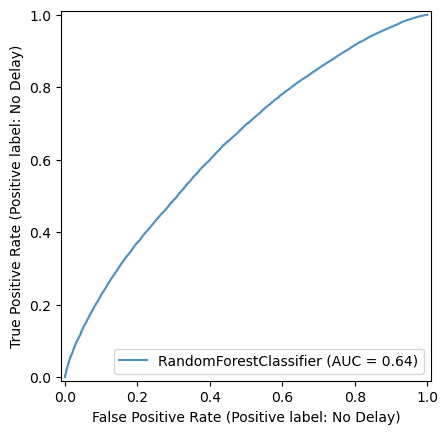

In [437]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(RandomForest, TestX, TestY, ax=ax, alpha=0.8)
plt.show()

Precision: How many of my Delay Predictions were correct?

Recall: Precent of positive cases that I caught

F1: What percent of positive predictions were correct?

Results for:
class_weight='balanced'
criterion = 'entropy'
n_estimators = 300
max_features = 'sqrt'
max_depth = None
min_samples_split = 4

In [421]:
print('Accuracy:', accuracy_score(TestY, Pred_Y))
print(classification_report(TestY, Pred_Y))

Accuracy: 0.7972825951548472
              precision    recall  f1-score   support

       Delay       0.43      0.14      0.21     23348
    No Delay       0.82      0.96      0.88     97061

    accuracy                           0.80    120409
   macro avg       0.63      0.55      0.55    120409
weighted avg       0.75      0.80      0.75    120409



In [418]:
cm = confusion_matrix(TestY, Pred_Y)
print(cm)


[[ 3192 20156]
 [ 4253 92808]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   15.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.1min


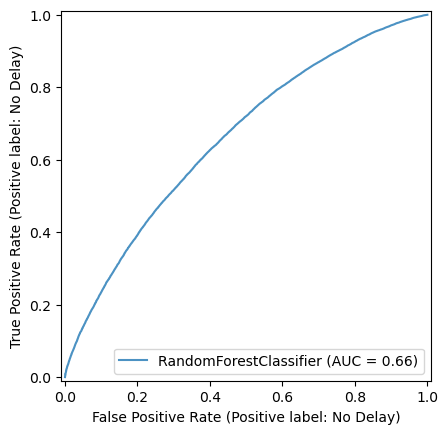

In [420]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(RandomForest, TestX, TestY, ax=ax, alpha=0.8)
plt.show()

#### Feature Importance

Using code found in SKLearn https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html to get an initial look at featurs, I understand the flaws with this feature and will be running permutation_importance next

In [215]:
features = list(TrainX.columns)

importances = RandomForest.feature_importances_
std = np.std([RandomForest.feature_importances_ for tree in RandomForest.estimators_], axis=0)

In [230]:
forest_importances = pd.Series(importances, index=features)
forest_importances.sort_values(ascending=False).head(10)

PRCP                          0.073137
Elapsed Time Difference       0.067543
Month                         0.051129
Airline_American              0.035234
WTTrue                        0.031639
Airline_USAirways             0.031616
Airline_JetBlue               0.028687
Destination Region_Eastern    0.028514
AWND                          0.024777
WTTrue                        0.021695
dtype: float64

Given we have around 3000 featues (from creating dummy variable :) ), this will take longer to comute than originally thought

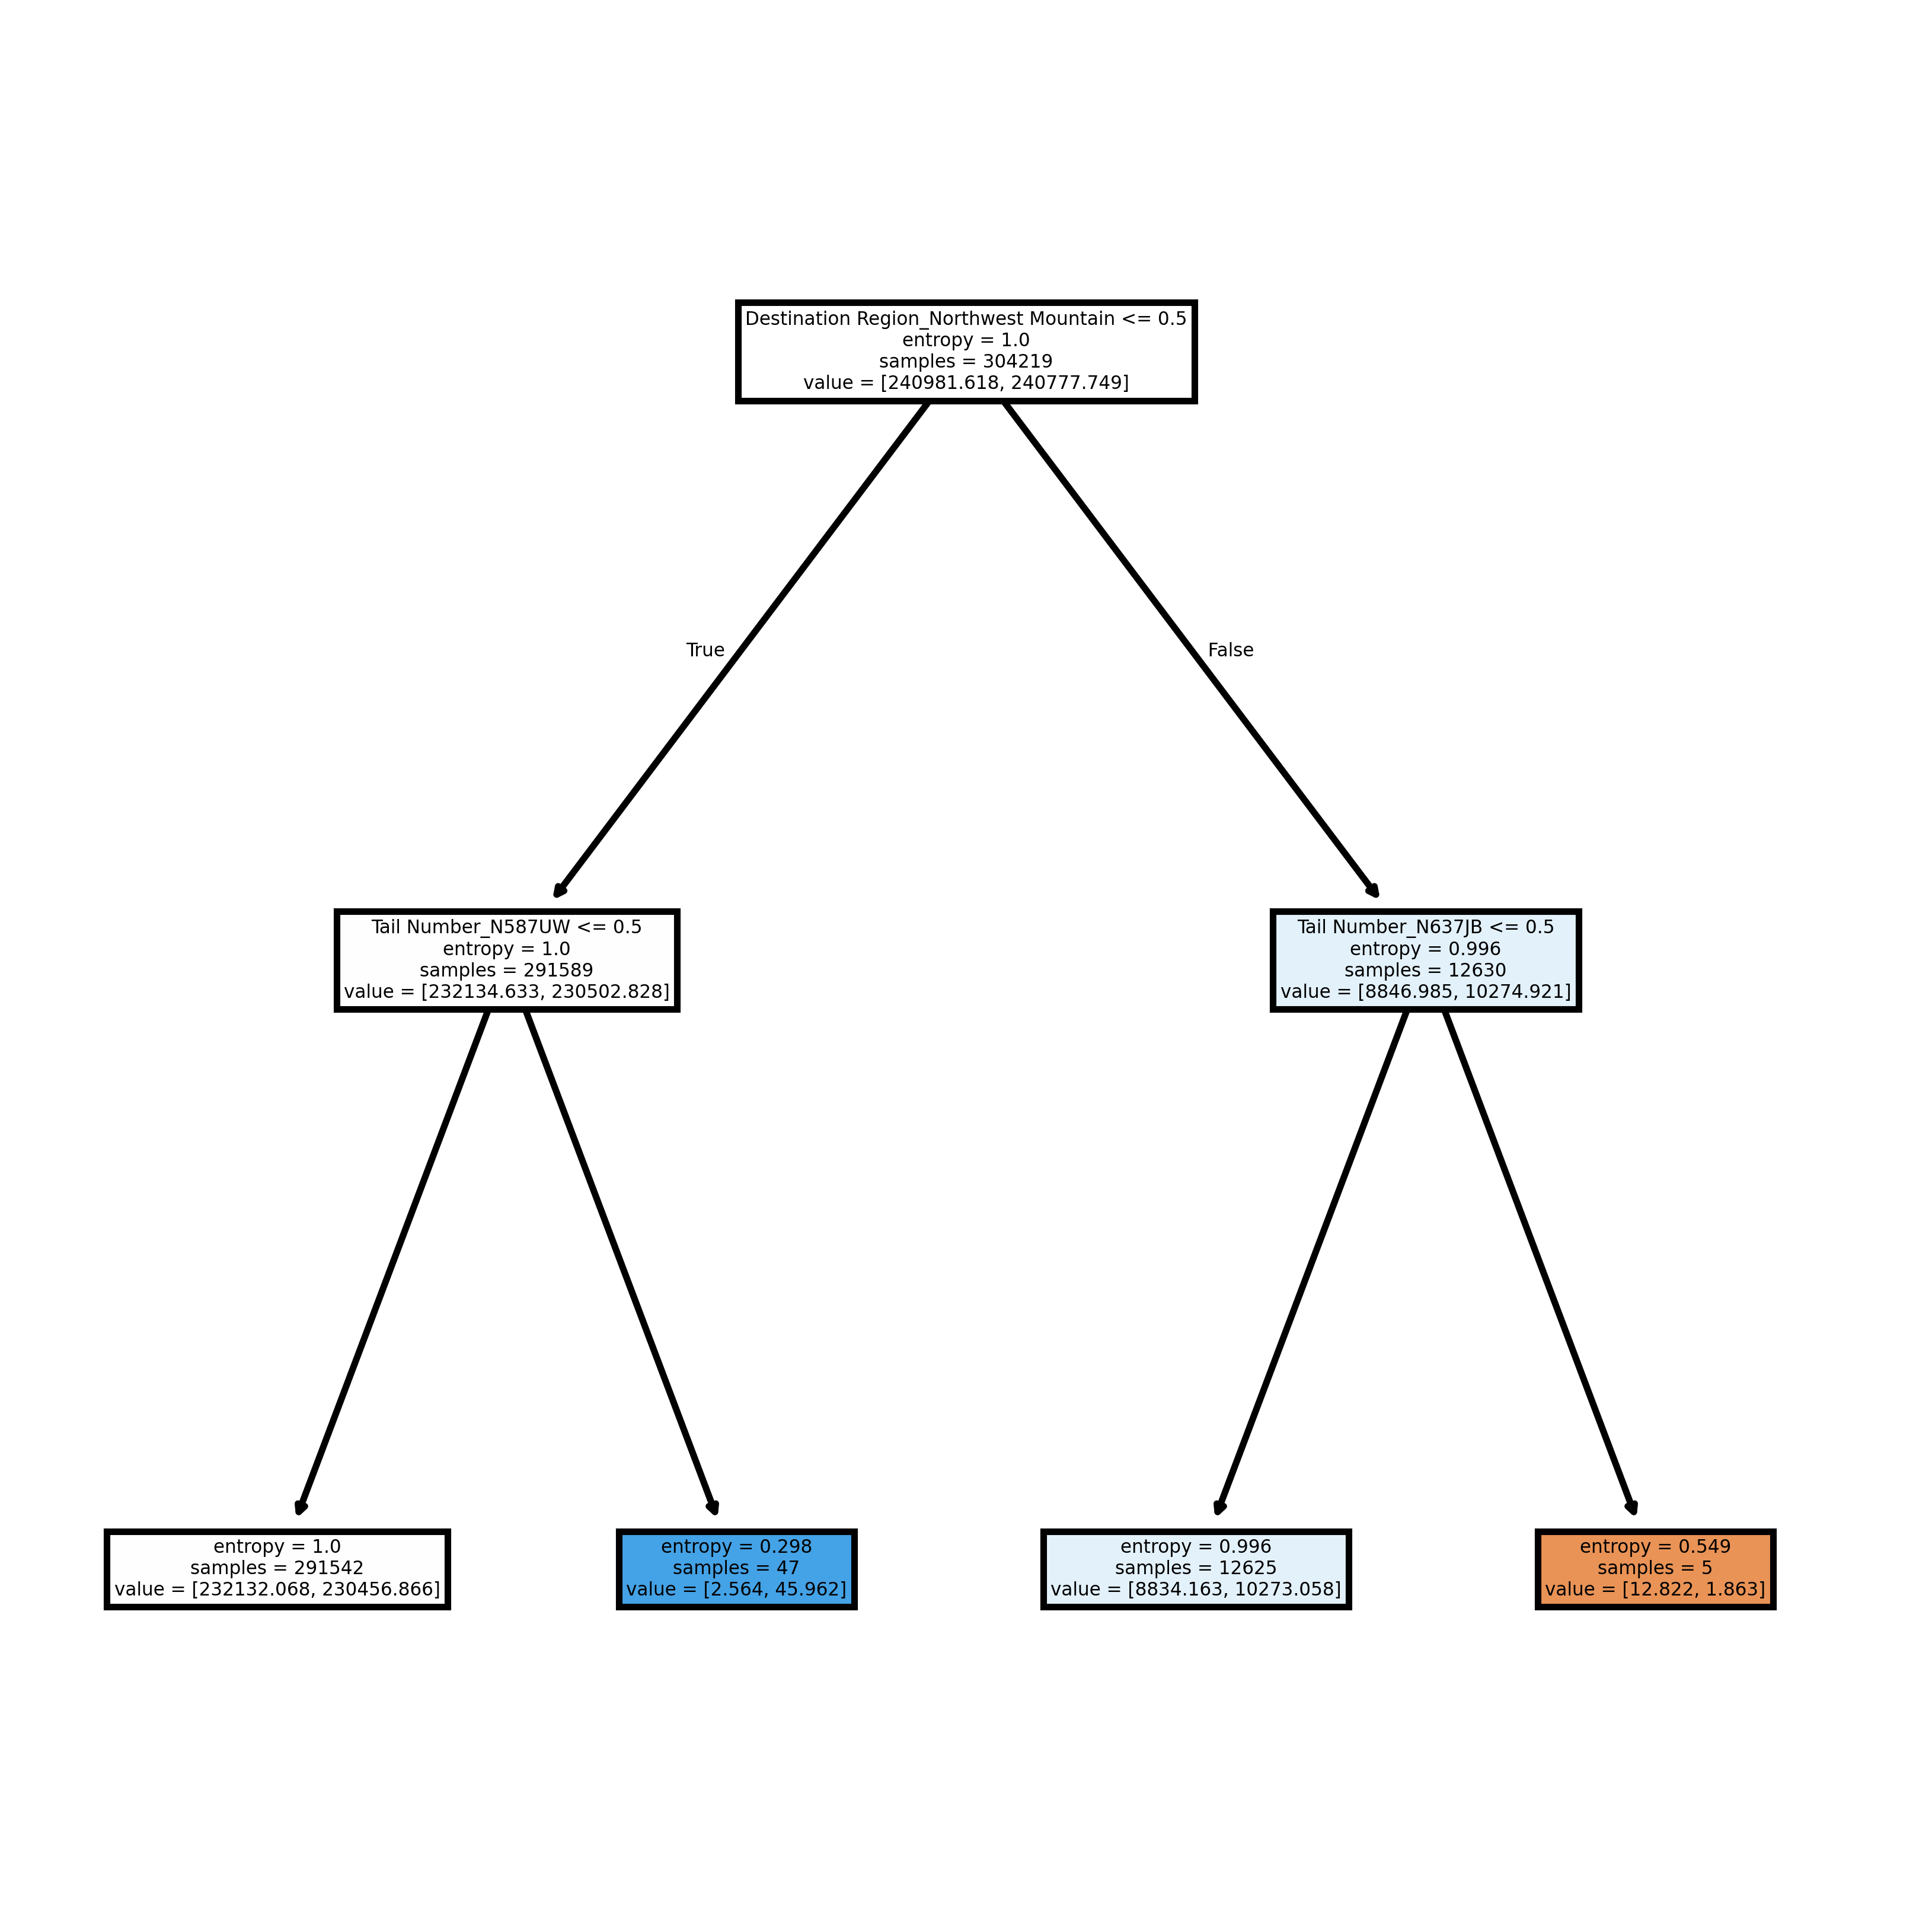

In [193]:
fn=TrainX.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=800)
tree.plot_tree(Fit_Rand.estimators_[0],
               feature_names = fn,
               filled = True);

#### Testing Parameters

First Parameter to check is criterion, we will test entropy and gini but not log loss (not currently functional with Random)

In [197]:
RandomForestparam1 = RandomForestClassifier(oob_score=True, class_weight='balanced', n_estimators = 100)
parameters = {'criterion': ['entropy', 'gini']}
test_Criterion = GridSearchCV(RandomForestparam1, parameters, scoring='accuracy', verbose=2)
Results_Criterion = test_Criterion.fit(TrainX, TrainY)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..................................criterion=entropy; total time=35.7min
[CV] END ..................................criterion=entropy; total time=34.9min


KeyboardInterrupt: 

In [122]:
# Print the best parameters and score
print("Best parameters:", Results_Criterion.best_params_)
print("Best score:", Results_Criterion.best_score_)

Best parameters: {'criterion': 'entropy'}
Best score: 0.8321999999999999


Testing n estimators, looking to go up to 100 as a computationally safe option, further testing can look at larger estimators

In [124]:
RandomForestparam2 = RandomForestClassifier(oob_score=True, class_weight='balanced', criterion = 'entropy')
parameters = {'n_estimators': [5,10,20,35,60,100]}
test_Criterion = GridSearchCV(RandomForestparam2, parameters, scoring='accuracy', verbose=2)
Results_Criterion = test_Criterion.fit(TrainX, TrainY)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END .....................................n_estimators=5; total time=   1.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END .....................................n_estimators=5; total time=   1.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END .....................................n_estimators=5; total time=   1.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END .....................................n_estimators=5; total time=   1.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END .....................................n_estimators=5; total time=   1.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=10; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=10; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=10; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=10; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=10; total time=   2.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


[CV] END ....................................n_estimators=20; total time=   4.1s
[CV] END ....................................n_estimators=20; total time=   3.7s
[CV] END ....................................n_estimators=20; total time=   3.6s
[CV] END ....................................n_estimators=20; total time=   4.4s
[CV] END ....................................n_estimators=20; total time=   4.1s
[CV] END ....................................n_estimators=35; total time=   6.2s
[CV] END ....................................n_estimators=35; total time=   6.2s
[CV] END ....................................n_estimators=35; total time=   7.0s
[CV] END ....................................n_estimators=35; total time=   6.9s
[CV] END ....................................n_estimators=35; total time=   7.4s
[CV] END ....................................n_estimators=60; total time=  11.2s
[CV] END ....................................n_estimators=60; total time=  10.5s
[CV] END ...................

In [128]:
# Print the best parameters and score
print("Best parameters:", Results_Criterion.best_params_)
print("Best score:", Results_Criterion.best_score_)

Best parameters: {'n_estimators': 100}
Best score: 0.8381000000000001


Testing for max features we use log2 and sqrt but auto is the same in classification Random

In [130]:
RandomForestparam3 = RandomForestClassifier(oob_score=True, class_weight='balanced', criterion = 'entropy', n_estimators = 100)
parameters = {'max_features': ['log2', 'sqrt']}
test_Criterion = GridSearchCV(RandomForest, RandomForestparam3, scoring='accuracy', verbose=2)
Results_Criterion = test_Criterion.fit(TrainX, TrainY)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..................................max_features=log2; total time=  18.8s
[CV] END ..................................max_features=log2; total time=  18.7s
[CV] END ..................................max_features=log2; total time=  19.8s
[CV] END ..................................max_features=log2; total time=  20.3s
[CV] END ..................................max_features=log2; total time=  20.0s
[CV] END ..................................max_features=sqrt; total time=  19.7s
[CV] END ..................................max_features=sqrt; total time=  20.1s
[CV] END ..................................max_features=sqrt; total time=  18.8s
[CV] END ..................................max_features=sqrt; total time=  19.4s
[CV] END ..................................max_features=sqrt; total time=  19.9s
[CV] END ..................................max_features=auto; total time=   0.0s
[CV] END ..................................max_fe

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-packag

In [132]:
# Print the best parameters and score
print("Best parameters:", Results_Criterion.best_params_)
print("Best score:", Results_Criterion.best_score_)

Best parameters: {'max_features': 'sqrt'}
Best score: 0.8378


Testing max depth, ideally not looking beyond 5 but wanted to test 10

In [138]:
RandomForestparam4 = RandomForestClassifier(oob_score=True, class_weight='balanced', criterion = 'entropy', n_estimators = 100, max_features = 'sqrt')
parameters = {'max_depth': [2, 3, 5, 10]}
test_Criterion = GridSearchCV(RandomForestparam4, parameters, scoring='accuracy', verbose=2)
Results_Criterion = test_Criterion.fit(TrainX, TrainY)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ........................................max_depth=2; total time=   8.4s
[CV] END ........................................max_depth=2; total time=   8.2s
[CV] END ........................................max_depth=2; total time=   7.7s
[CV] END ........................................max_depth=2; total time=   7.9s
[CV] END ........................................max_depth=2; total time=   8.4s
[CV] END ........................................max_depth=3; total time=   7.8s
[CV] END ........................................max_depth=3; total time=   8.0s
[CV] END ........................................max_depth=3; total time=   8.9s
[CV] END ........................................max_depth=3; total time=   9.2s
[CV] END ........................................max_depth=3; total time=   9.3s
[CV] END ........................................max_depth=5; total time=   9.1s
[CV] END ........................................

In [140]:
# Print the best parameters and score
print("Best parameters:", Results_Criterion.best_params_)
print("Best score:", Results_Criterion.best_score_)

Best parameters: {'max_depth': 2}
Best score: 0.8582000000000001


Testing the Min samples split, looking at 2, 3, and 5

In [146]:
RandomForestparam5 = RandomForestClassifier(oob_score=True, criterion = 'entropy', n_estimators = 100, max_features = 'sqrt', max_depth = 2)
parameters = {'min_samples_split': [2, 3, 5]}
test_Criterion = GridSearchCV(RandomForestparam5, parameters, scoring='accuracy', verbose=2)
Results_Criterion = test_Criterion.fit(TrainX, TrainY)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................min_samples_split=2; total time=   8.7s
[CV] END ................................min_samples_split=2; total time=   8.7s
[CV] END ................................min_samples_split=2; total time=   8.6s
[CV] END ................................min_samples_split=2; total time=   8.3s
[CV] END ................................min_samples_split=2; total time=   8.3s
[CV] END ................................min_samples_split=3; total time=   8.0s
[CV] END ................................min_samples_split=3; total time=   8.0s
[CV] END ................................min_samples_split=3; total time=   8.0s
[CV] END ................................min_samples_split=3; total time=   7.8s
[CV] END ................................min_samples_split=3; total time=   7.9s
[CV] END ................................min_samples_split=5; total time=   8.0s
[CV] END ................................min_samp

In [148]:
# Print the best parameters and score
print("Best parameters:", Results_Criterion.best_params_)
print("Best score:", Results_Criterion.best_score_)

Best parameters: {'min_samples_split': 2}
Best score: 0.8582000000000001


Test the smalls amount of samples needed to make a leaf node, looking at 1 5 and 8. With the size of the dataset 

In [150]:
RandomForestparam6 = RandomForestClassifier(oob_score=True, class_weight='balanced', criterion = 'entropy', n_estimators = 100, max_features = 'sqrt', max_depth = 2, min_samples_split = 2)
parameters = {'min_samples_leaf': [1,5,8]}
test_Criterion = GridSearchCV(RandomForestparam6, parameters, scoring='accuracy', verbose=2)
Results_Criterion = test_Criterion.fit(TrainX, TrainY)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .................................min_samples_leaf=1; total time=   8.1s
[CV] END .................................min_samples_leaf=1; total time=   7.7s
[CV] END .................................min_samples_leaf=1; total time=   7.7s
[CV] END .................................min_samples_leaf=1; total time=   8.3s
[CV] END .................................min_samples_leaf=1; total time=   8.1s
[CV] END .................................min_samples_leaf=5; total time=   7.9s
[CV] END .................................min_samples_leaf=5; total time=   8.3s
[CV] END .................................min_samples_leaf=5; total time=   8.0s
[CV] END .................................min_samples_leaf=5; total time=   8.1s
[CV] END .................................min_samples_leaf=5; total time=   7.8s
[CV] END .................................min_samples_leaf=8; total time=   7.8s
[CV] END .................................min_sam